# Explore vs. exploit

Here, we investigate different strategies for how to make the suggestion for the next
point to sample.

This notebook is a part of the series about using ProcessOptimizer to guide a gold
mining expedition. For an overview, go to the markdown file gold_mining.md

## What we learned last time
We define our map by setting `coordinates`, and our `score()` function. We then
initialise a ProcessOptimizer on the `coordinates`. We then do 10 cycles of asking for
a place to dig, sending Ms. Dixon's team to dig, and telling the ProcessOptimizer how
much gold was found.

Lastly, we plot the **secret** gold map, so we can evaluate whether the models built
look like the actual scoring function.

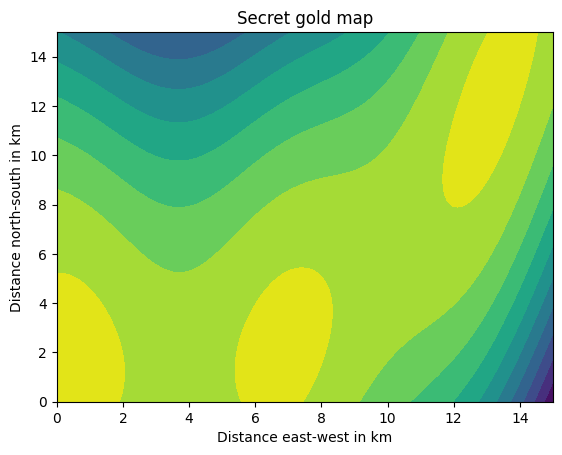

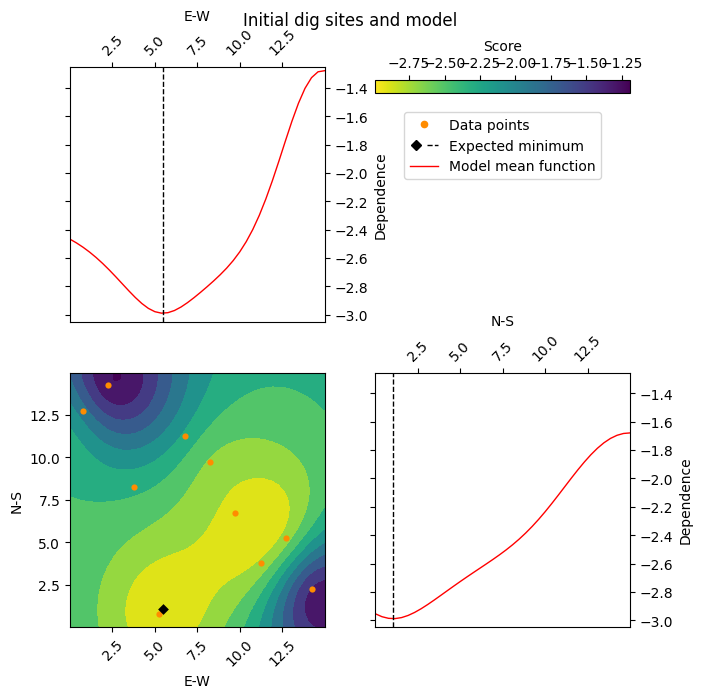

In [1]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import ProcessOptimizer
from ProcessOptimizer.model_systems.model_system import ModelSystem

#Setting random seed to ensure reproducible behaviour
np.random.seed(42)

VERBOSE = False

coordinates = [(0, 15.0),(0,15.0)]

num_digs = 10

def score(coordinates: List[int]):
    """ Modified Branin-Hoo function. It has three local minima.
    More details: <http://www.sfu.ca/~ssurjano/branin.html>
    """
    x = 10-coordinates[0]
    y = coordinates[1]
    gold_found = ((y - 1/8 * x ** 2 + 1.6 * x - 6) ** 2 + 10 * np.cos(x) - 299)/100
    if VERBOSE:
        print(f"We dug at {coordinates} and found {-round(gold_found*10)/10} mg gold.")
    return gold_found

# Making the data model
data_model = ModelSystem(score=score,space=coordinates,noise_model="zero")

opt = ProcessOptimizer.Optimizer(dimensions=coordinates)
# For each of the first 10 positions
for index in range(10):
    # Find the place to dig
    new_dig_site = opt.ask()
    # Digging for gold
    gold_found = data_model.get_score(new_dig_site)
    # Telling the optimiser how uch gold we found
    result = opt.tell(new_dig_site, gold_found)


#Plotting the secret map
# Making the lists of x and y coordinates
x_list = np.linspace(coordinates[0][0],coordinates[0][1],100)
y_list = np.linspace(coordinates[1][0],coordinates[1][1],100)

(x_mesh,y_mesh) = np.meshgrid(x_list,y_list)
score_mesh = [[-data_model.score((x,y)) for (x,y) in zip(x_vec,y_vec)] 
              for (x_vec,y_vec) in zip(x_mesh,y_mesh)]
plot = plt.contourf(x_mesh,y_mesh,score_mesh,10)
plot.axes.set_xlabel("Distance east-west in km")
plot.axes.set_ylabel("Distance north-south in km")
plot.axes.set_title("Secret gold map")
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"],title="Initial dig sites and model");

## What to value when picking the next point

The next time Ms. Dixon goes to the office, she gets into an argument with a colleague,
Mr. Map Drawson. Ms. Dixon wants dig where she expects to find the most
gold, while Mr. Drawson wants to plan for a bigger operation later, so he is more
interested in the knowledge the dig gives them of where the gold is in the plot of land.

These two approaches is known as **Exploit** (Ms. Dixons's approach), where we value
getting a good result over getting more knowlegde, and **Explore** (Mr. Drawsons's
approach), where we value reducing uncertainties about how good different parameter
settings are. It isn't a dichotomy where we have to choose one or the other, we can
choose different balances between the two considerations.

The balance is determined by the property of ProcessOptimizer `acq_func_kwargs`, which
is a `dict`. In the default ProcessOptimizer, the value of `acq_func_kwargs["xi"]`
determines where the balance lies. the lower the value, the more exploiting the
ProcessOptimizer becomes.

Let's first run it with the defult settings, where `xi = 0.01`, so we have something to
compare the other settings to.

We dug at [7.253715855658406, 3.4548660037768077] and found 3.1 mg gold.
We dug at [14.265721096859975, 11.955358106173726] and found 2.9 mg gold.
We dug at [12.371368916745384, 9.387116564027963] and found 3.0 mg gold.
We dug at [0.0, 0.19837319999778727] and found 3.0 mg gold.
We dug at [0.0, 4.332470618435088] and found 3.0 mg gold.
We dug at [12.011581537338888, 15.0] and found 2.8 mg gold.
We dug at [7.884424806317732, 0.0] and found 2.9 mg gold.
We dug at [6.9416066721395, 2.684857352876112] and found 3.1 mg gold.
We dug at [1.7145880542133827, 1.5657258758022772] and found 3.0 mg gold.
We dug at [15.0, 15.0] and found 2.9 mg gold.
We dug at [5.886208279671589, 3.6569826555756175] and found 3.0 mg gold.
We dug at [0.0, 2.4171436344970667] and found 3.1 mg gold.
Found 2.993773706357226 mg of gold on average


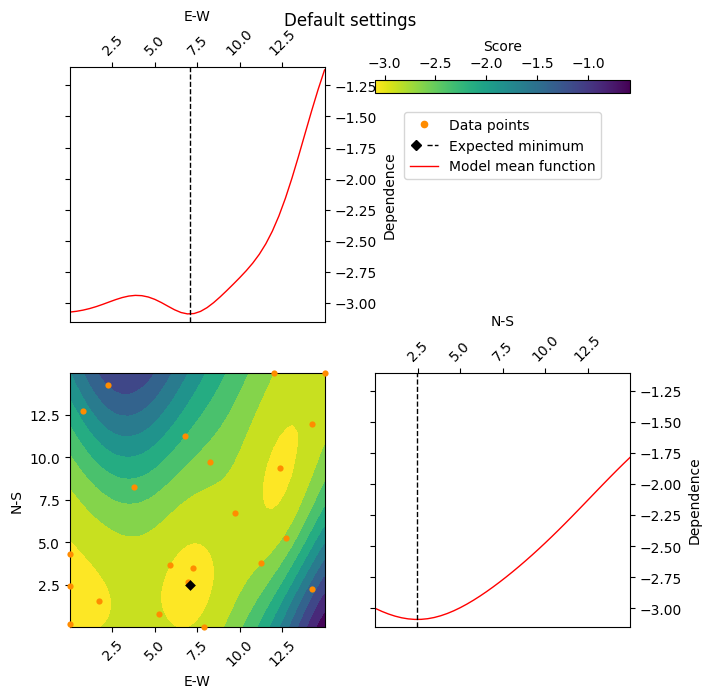

In [2]:
VERBOSE = True
default_opt = opt.copy()
default_opt.acq_func_kwargs = {"xi": 0.01}
default_opt.update_next()
total_gold_found = 0
for _ in range(num_digs):
    new_point = default_opt.ask()
    gold_found = data_model.get_score(new_point)
    total_gold_found += gold_found
    result = default_opt.tell(new_point,gold_found)
print(f"Found {-total_gold_found/num_digs} mg of gold on average")
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"],title="Default settings");

## Exploiting

Now let's try amd let Ms. Dixon decide where to dig; That is, using a more exploiting
ProcessOptimizer. To do this, we set `xi` lower than the default.

We dug at [7.253716031336352, 3.4548648122370373] and found 3.1 mg gold.
We dug at [14.26572015787362, 11.955357669410537] and found 2.9 mg gold.
We dug at [7.234130194536043, 3.3836713958949822] and found 3.1 mg gold.
We dug at [0.0, 0.02074399860487889] and found 3.0 mg gold.
We dug at [0.0, 4.945844459746195] and found 3.0 mg gold.
We dug at [11.844911744251556, 15.0] and found 2.7 mg gold.
We dug at [7.168503849475178, 3.1907636861224504] and found 3.1 mg gold.
We dug at [12.379070208391616, 9.580452308912152] and found 3.1 mg gold.
We dug at [7.074579925771888, 2.9311277604960724] and found 3.1 mg gold.
We dug at [6.992910449749963, 2.7207546270014955] and found 3.1 mg gold.
We dug at [7.4935430563706875, 0.0] and found 3.0 mg gold.
We dug at [1.8154320211829742, 1.5225659062606638] and found 3.0 mg gold.
Found 3.011069592493644 mg of gold on average


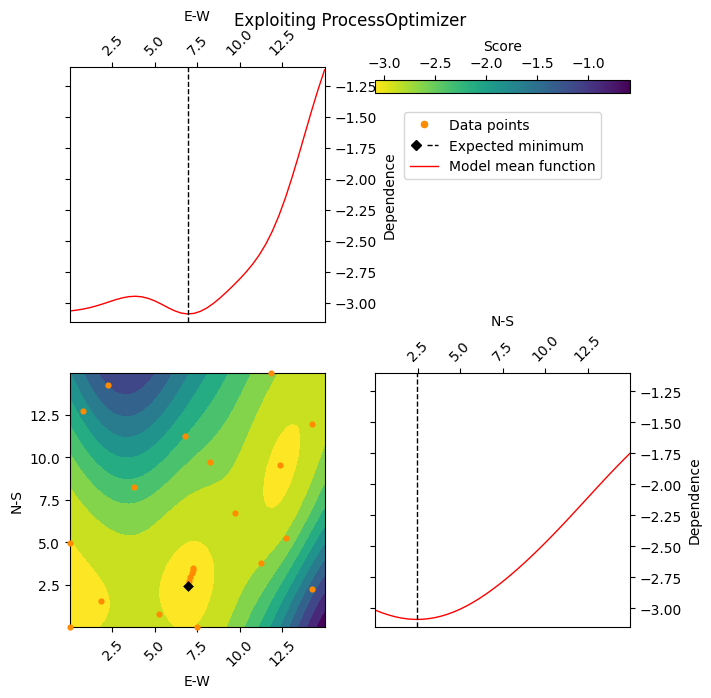

In [3]:
exploiting_opt = opt.copy()
exploiting_opt.acq_func_kwargs = {"xi": 0.00001}
exploiting_opt.update_next()
total_gold_found = 0
for _ in range(num_digs):
    new_point = exploiting_opt.ask()
    gold_found = data_model.get_score(new_point)
    total_gold_found += gold_found
    result = exploiting_opt.tell(new_point,gold_found)
print(f"Found {-total_gold_found/num_digs} mg of gold on average")
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"], title="Exploiting ProcessOptimizer");


Notice that the averge amount of gold found is higher than for the default, if only
slightly so; the default optimizer is pretty good at only digging at optimal places for
this score function.

Around half of the digs are very close to each other, around one of the optima.

So the exploiting ProcessOptimizer is less adventurous, but tends to give better results
for the parameters is suggest.

## Exploring

Now let's try and build an exploring ProcessOptimizer instead. To do this, we set `xi`
higher than the default of 0.01.

We dug at [7.253715816588949, 3.4548658747966727] and found 3.1 mg gold.
We dug at [3.264764149895623, 5.498367846087172] and found 2.7 mg gold.
We dug at [3.3014915702726157, 6.796495513048718] and found 2.5 mg gold.
We dug at [14.929919630635176, 15.0] and found 2.9 mg gold.
We dug at [8.046899092402624, 0.3131858310491226] and found 2.9 mg gold.
We dug at [0.0, 0.0] and found 3.0 mg gold.
We dug at [12.062917395276239, 15.0] and found 2.8 mg gold.
We dug at [5.525497188191589, 11.70925552267838] and found 1.9 mg gold.
We dug at [0.0, 4.701464809080416] and found 3.0 mg gold.
We dug at [13.252493067293955, 10.804276311004791] and found 3.1 mg gold.
We dug at [11.95499338337648, 9.232707737258707] and found 3.0 mg gold.
We dug at [2.0240784949788186, 0.0] and found 3.0 mg gold.
Found 2.833179120810224 mg of gold on average


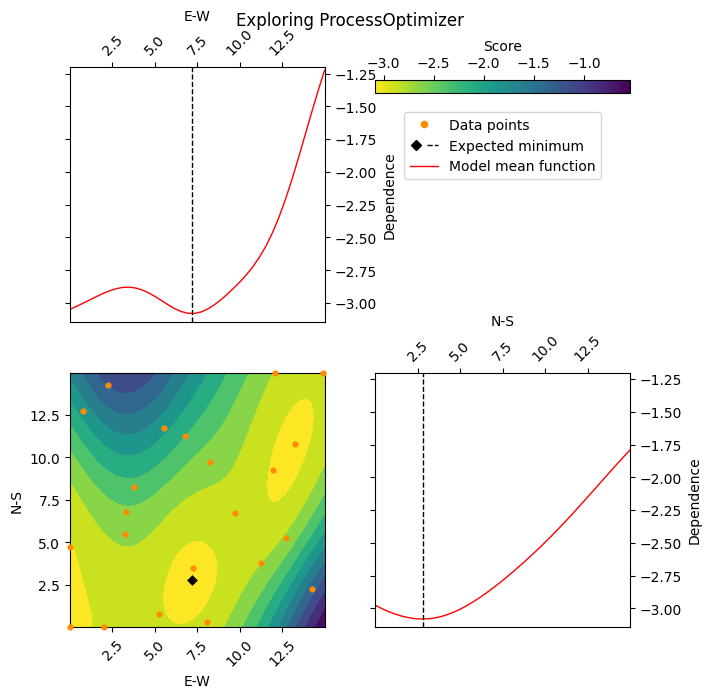

In [4]:
exploring_opt = opt.copy()
exploring_opt.acq_func_kwargs = {"xi": 1000}
exploring_opt.update_next()
total_gold_found = 0
for _ in range(num_digs):
    new_point = exploring_opt.ask()
    gold_found = data_model.get_score(new_point)
    total_gold_found += gold_found
    result = exploring_opt.tell(new_point,gold_found)
print(f"Found {-total_gold_found/num_digs} mg of gold on average")
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"], title="Exploring ProcessOptimizer");


The average amount of gold found is lower. You an also see that the digs are more spread
out that for the default - All of the new digs for the default is in yellow or light
green areas, where the exploring ProcessOptimizer has digs in the more bluish bluish
areas, where the model predicts that little gold is present. This is because the model
had high uncertainty in these areas, so even if it predicted that little gold would be
found, the small chance that a lot of gold was present here made the ProcessOptimizer
suggest digging there.